In [0]:
#sandbox =  
#PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [0]:
! pip install findspark

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
DATAPATH = os.path.join('content', 'drive', 'My Drive', '2019Q2_DSPF_contents' , 'workshop_spark', 'data') 
filepath = os.path.join(DATAPATH, 'bank-full.csv')
print(filepath)

content/drive/My Drive/2019Q2_DSPF_contents/workshop_spark/data/bank-full.csv


# Importación Librerías

In [0]:
from pyspark.sql import functions as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics

import seaborn as sns



# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Lectura de datos

- Importamos el csv bank-full y lo mostramos para comprobar su carga correcta

In [0]:
loan_df = spark.read.csv('file:///' + filepath, sep=';', header=True, inferSchema=True)
loan_df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar| married| 

## Primer Análisis de los datos

- Estudiamos contenido y tipos de variables

In [0]:
loan_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [0]:
loan_df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('y', 'string'),
 ('picked_up_call', 'int'),
 ('extra_info', 'int')]

- Creamos una función para estudiar la dimension del df y almacenamos en variable dim

In [0]:
# Devuelve el size del df
def size(df):
  nrows=df.count()
  ncols=len(df.columns)
  return [nrows, ncols]

In [0]:
dim=size(loan_df)
dim


[45211, 20]

- Almacenamos 3 listas:

      1) lista de columnas y tipos

      2) lista de variables cuantitativas

      3) lista de variables cualitativas


In [0]:
lista_var = loan_df.dtypes
lista_var_int = [c for c,t in lista_var if t in ['int','double']]
lista_var_str = [c for c,t in lista_var if t in ['string','boolean']]

In [0]:
lista_var_str

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

## Análisis de duplicados

Comparamos el número de registros original con el dropDuplicates

In [0]:
no_dup=loan_df.dropDuplicates().count()

In [0]:
if dim[0] == no_dup:
  print("No hay duplicados")
else:
    print("Hay duplicados")

No hay duplicados


## Análisis de Nulos

In [0]:
missing_ops = [F.sum(F.col(c).isNull().cast('int')).alias(c) for c in loan_df.columns]
loan_df_nulos=loan_df.select(missing_ops)
loan_df_nulos.show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|   0|       0|       0|    0|       0|       0|  0|             0|     45133|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+



In [0]:
num_nulos = loan_df_nulos.toPandas().T
num_nulos

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [0]:
col_max_nulos = num_nulos.idxmax().values[0]
print(col_max_nulos)

extra_info


El único campo que presenta nulos es 'extra_info'

## Análisis de valores únicos por columna

- Calculamos frecuencias para todas las columnas, ordenando por frecuencia máxima para ver concentración de valores.

In [0]:
for c in loan_df.columns:
  df=loan_df.groupBy(F.col(c)).count().sort(F.col('count'),ascending=False).withColumn('Frec', F.round(F.col('count')/dim[0]*100,2))
  print(df.show())

+---+-----+----+
|age|count|Frec|
+---+-----+----+
| 32| 2085|4.61|
| 31| 1996|4.41|
| 33| 1972|4.36|
| 34| 1930|4.27|
| 35| 1894|4.19|
| 36| 1806|3.99|
| 30| 1757|3.89|
| 37| 1696|3.75|
| 39| 1487|3.29|
| 38| 1466|3.24|
| 40| 1355| 3.0|
| 41| 1291|2.86|
| 42| 1242|2.75|
| 45| 1216|2.69|
| 29| 1185|2.62|
| 46| 1175| 2.6|
| 43| 1161|2.57|
| 44| 1136|2.51|
| 47| 1088|2.41|
| 28| 1038| 2.3|
+---+-----+----+
only showing top 20 rows

None
+-------------+-----+-----+
|          job|count| Frec|
+-------------+-----+-----+
|  blue-collar| 9732|21.53|
|   management| 9458|20.92|
|   technician| 7597| 16.8|
|       admin.| 5171|11.44|
|     services| 4154| 9.19|
|      retired| 2264| 5.01|
|self-employed| 1579| 3.49|
| entrepreneur| 1487| 3.29|
|   unemployed| 1303| 2.88|
|    housemaid| 1240| 2.74|
|      student|  938| 2.07|
|      unknown|  288| 0.64|
+-------------+-----+-----+

None
+--------+-----+-----+
| marital|count| Frec|
+--------+-----+-----+
| married|27214|60.19|
|  single|12790

Tras el análisis visual de los campos, vemos que extra_info tiene un 99% de nulos.

Además hay valores desconocidos en:



- job = Unknown
- eduaction = Unknown
- contact = Unknown (resto de valores son telefóno o celular)
- pday = hace referencia a "pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)"" No aplica el valor -1
- poutcome = Unknown y Other (categorizar como "nonexistent")


Eliminamos la columna extra_info por no aportar información

In [0]:
loan_df=loan_df.drop(F.col('extra_info'))

In [0]:
size(loan_df)

[45211, 19]

## Cambio de formato y transformación de variables

- Creamos variables binarias para los yes,no

In [0]:
#Creamos lista con campos binarios#
lista_bin=[]
# Bucle for que crea df agrupado por cada variable string para incluirlo en la lista si la dimensión es = 2
for c in lista_var_str:
  df=loan_df.groupBy(F.col(c)).count().sort(F.col('count'),ascending=False)
  if size(df)[0]==2:
    lista_bin.append(c)

In [0]:
lista_bin

['default', 'housing', 'loan', 'y']

In [0]:
#Añadimos nuevos campos binarios para las variables (yes,no)  0s y 1s
for c in lista_bin:
  loan_df=loan_df.withColumn(c + '_bin', F.when(F.col(c)=='yes',1).otherwise(0))

In [0]:
loan_df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+-----------+-----------+--------+-----+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|default_bin|housing_bin|loan_bin|y_bin|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+-----------+-----------+--------+-----+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|          0|          1|       0|    0|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|          0|          1|       0|    0|
| 33|entrepreneur| married|secondary|     no|     

- Transformamos fecha. 

      Aunque los tipos de day y year son int, al concatenarlos el resultado es string

In [0]:
loan_df2=loan_df.withColumn('date',F.to_date(F.concat(F.col('year'),F.lit('-'),F.col('month'),F.lit('-'),F.col('day')),format='yyyy-MMM-dd'))

In [0]:

loan_df2.select(F.col('date')).show()
print(loan_df2.select(F.col('date')).dtypes)

+----------+
|      date|
+----------+
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
|2008-05-05|
+----------+
only showing top 20 rows

[('date', 'date')]


- Modificamos el nombre de la variable y a target, y_bin a target_bin

In [0]:
loan_df2=loan_df2.withColumnRenamed('y','target').withColumnRenamed('y_bin','target_bin')

In [0]:
loan_df2.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('target', 'string'),
 ('picked_up_call', 'int'),
 ('default_bin', 'int'),
 ('housing_bin', 'int'),
 ('loan_bin', 'int'),
 ('target_bin', 'int'),
 ('date', 'date')]

- Modificamos variable poutcome para los valores que no son failure o success a nonexistent conforme al enunciado

*"15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')"*

In [0]:
poutcome_vals=['failure','nonexistent','success']
loan_df2=loan_df2.withColumn('poutcome',F.when(F.col('poutcome').isin(poutcome_vals),F.col('poutcome')).otherwise('nonexistent'))

In [0]:
loan_df2.groupby(F.col('poutcome')).count().show()

+-----------+-----+
|   poutcome|count|
+-----------+-----+
|    success| 1511|
|    failure| 4901|
|nonexistent|38799|
+-----------+-----+



- Modificamos variable pdays para los valores -1 por 999 conforme al enunciado

*"13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)"*

In [0]:
loan_df2=loan_df2.withColumn('pdays',F.when(F.col('pdays')==-1,999).otherwise(F.col('pdays')))

In [0]:
loan_df2.groupby(F.col('pdays')).count().sort(F.col('count'),ascending=False).show()

+-----+-----+
|pdays|count|
+-----+-----+
|  999|36954|
|  182|  167|
|   92|  147|
|   91|  126|
|  183|  126|
|  181|  117|
|  370|   99|
|  184|   85|
|  364|   77|
|   95|   74|
|  350|   73|
|   94|   72|
|  175|   71|
|  185|   68|
|  343|   65|
|   93|   65|
|  188|   64|
|  189|   60|
|  186|   60|
|  349|   57|
+-----+-----+
only showing top 20 rows



Antes de seguir con el análisis univariante, actualizamos la lista de int y str

In [0]:
lista_var = loan_df2.dtypes
lista_var_int = [c for c,t in lista_var if t in ['int','double']]
lista_var_str = [c for c,t in lista_var if t in ['string','boolean']]

# Análisis univariante

Creamos df numéricos y categóricos

In [0]:
loan_df2_int=loan_df2.select(lista_var_int)
loan_df2_str=loan_df2.select(lista_var_str)

Convertimos todos los df a Pandas para graficar

In [0]:
loan_df2_P=loan_df2.toPandas()
loan_df2_str_P=loan_df2_str.toPandas()
loan_df2_int_p=loan_df2_int.toPandas()

## Variables cuantitativas

- Representamos todas las numéricas: histogramas, boxplot y scatter

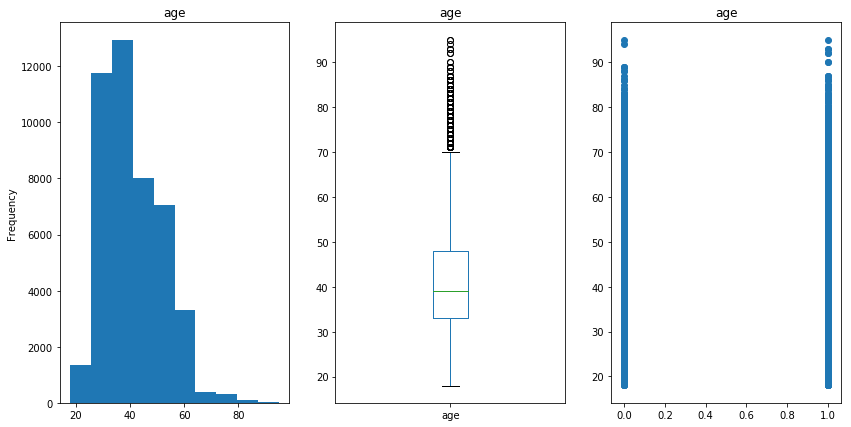

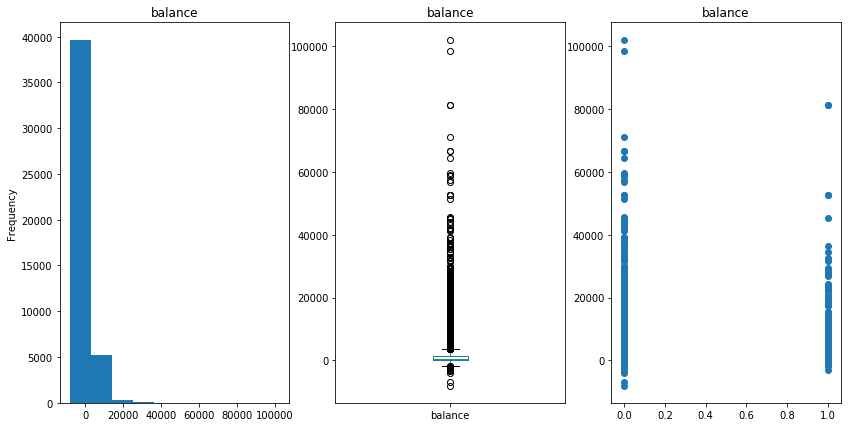

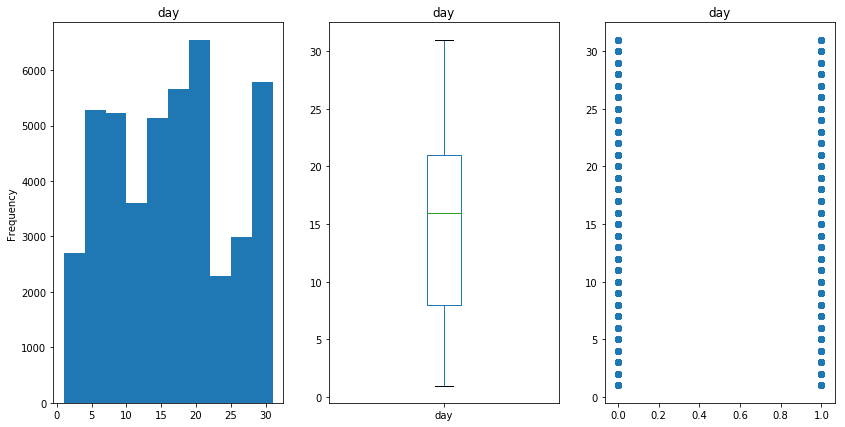

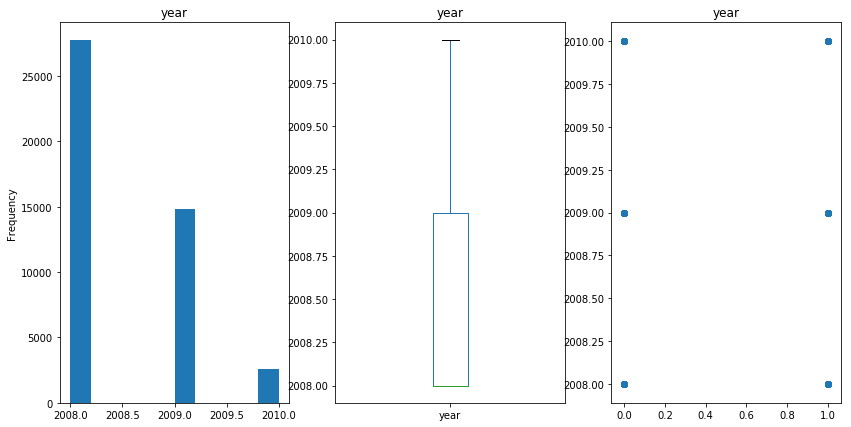

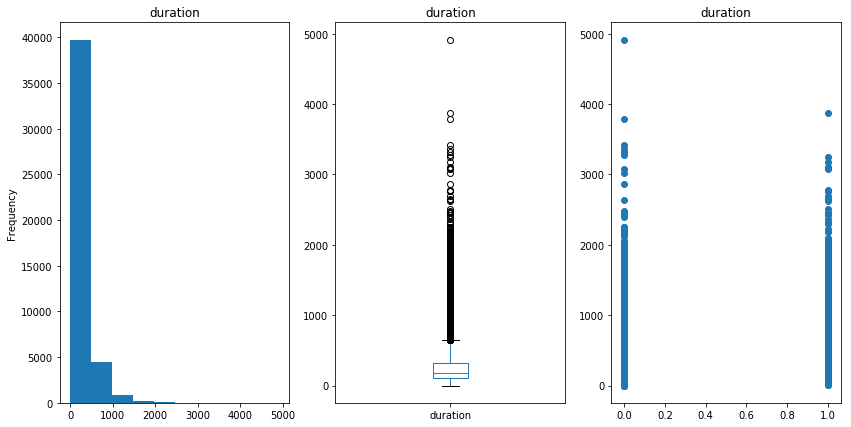

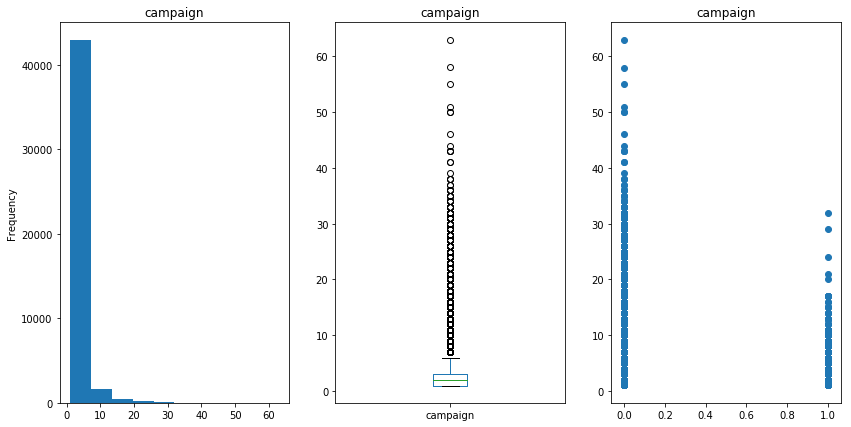

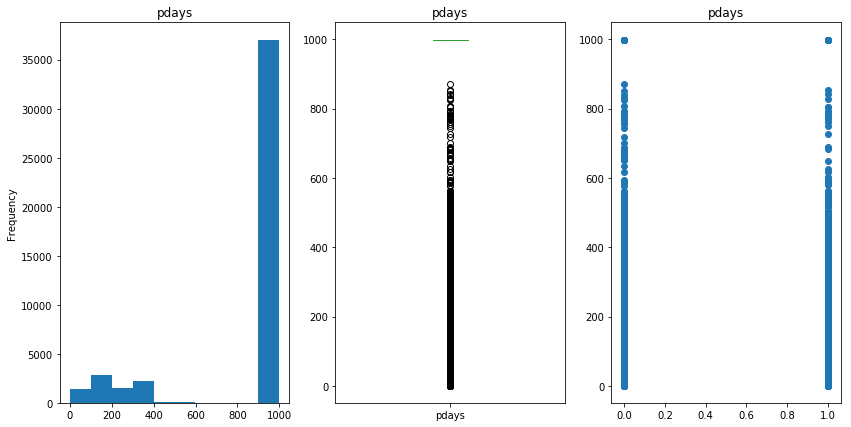

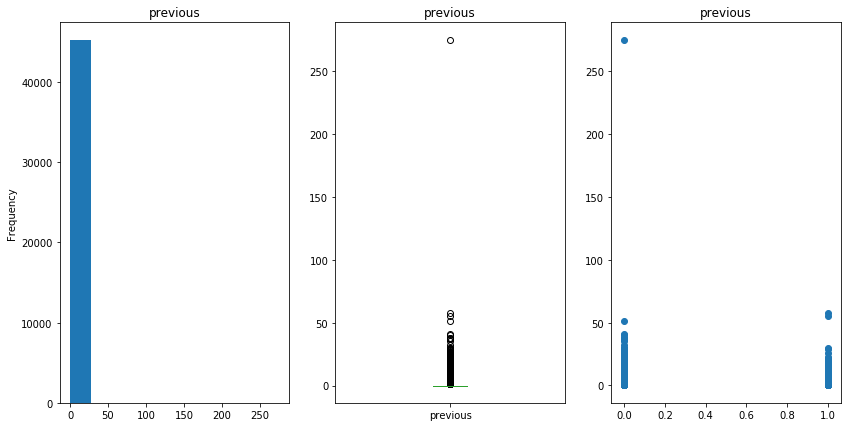

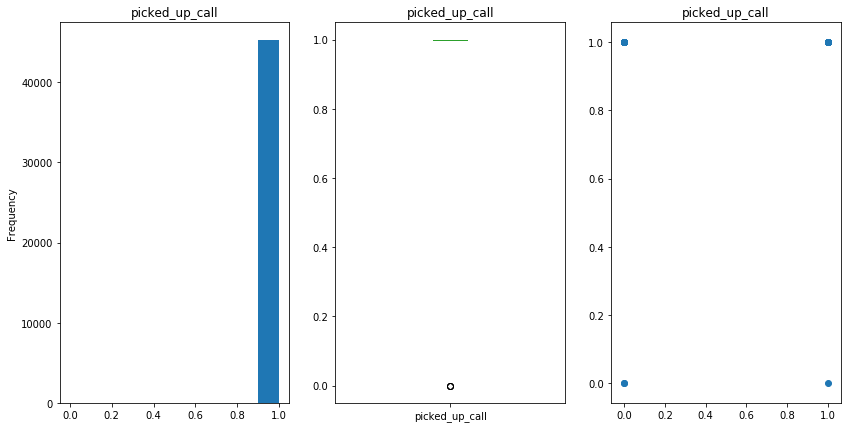

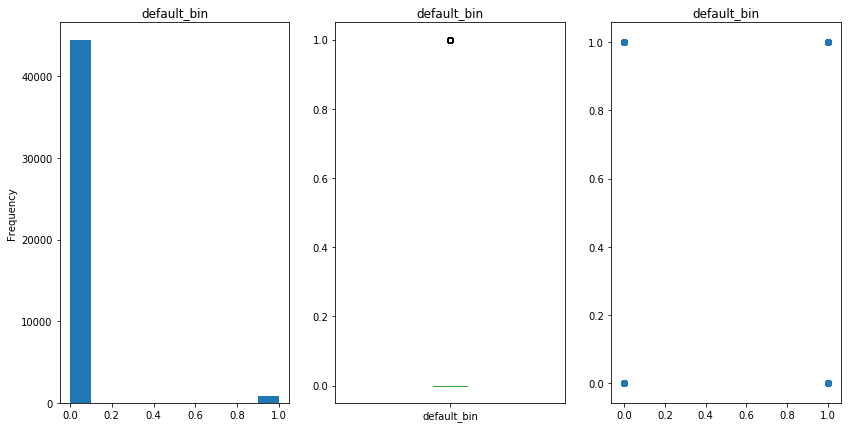

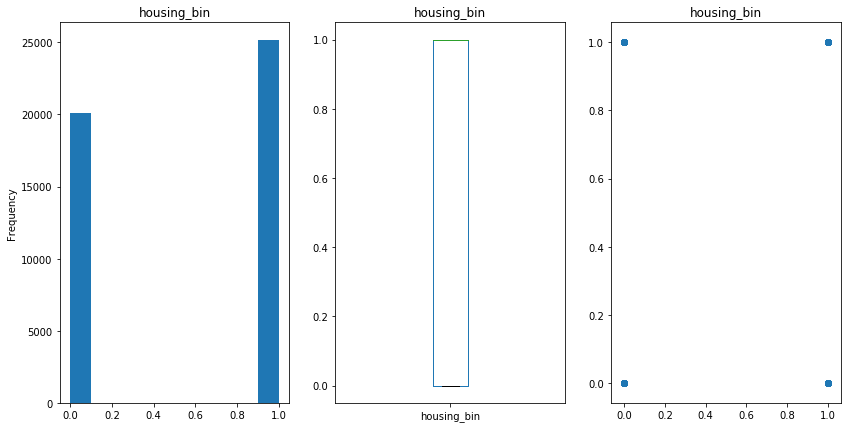

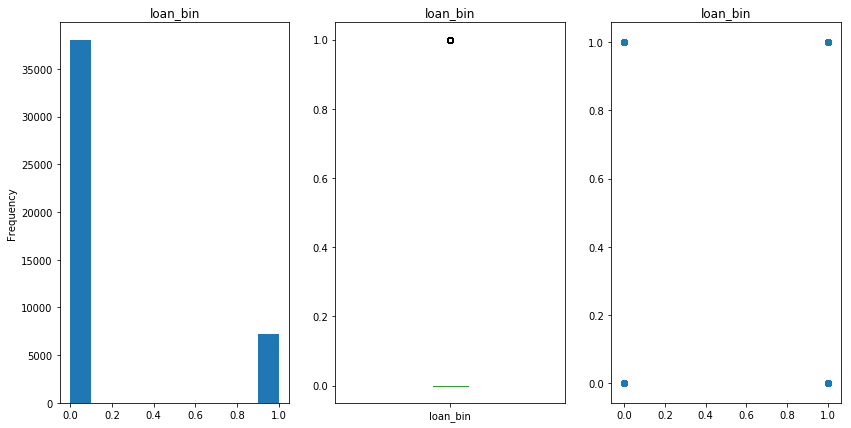

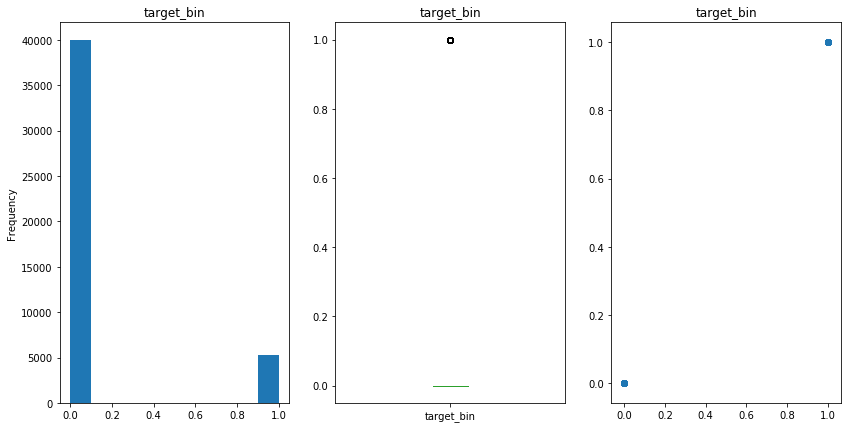

In [0]:
for x in lista_var_int:
  
    plt.figure(figsize=(14,7))
    plt.subplot(1, 3, 1)
    loan_df2_P[x].plot.hist()
    plt.title(x)
    
    plt.subplot(1, 3, 2)
    loan_df2_P[x].plot.box()
    plt.title(x)
    
    
    plt.subplot(1, 3, 3)
    plt.scatter(loan_df2_P['target_bin'], loan_df2_P[x])
    plt.title(x)
      
    plt.show()

## Variables categóricas

Tanto para variables cuantitativas como cualitativas antes hemos calculamos las frecuencias. Ahora  represenatamos gráficamente las categóricas:



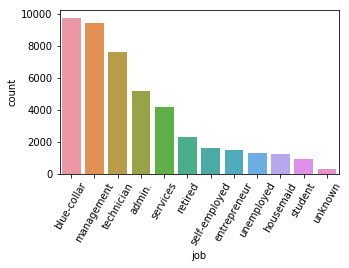

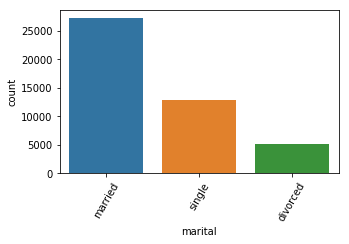

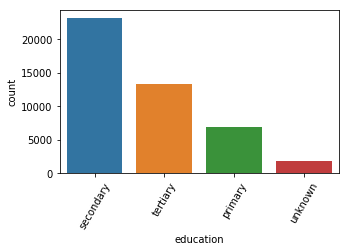

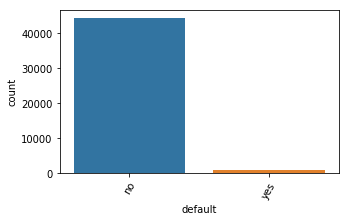

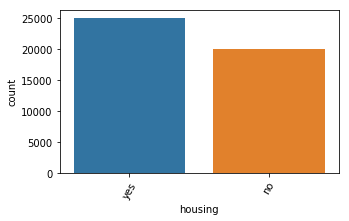

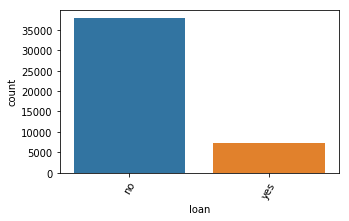

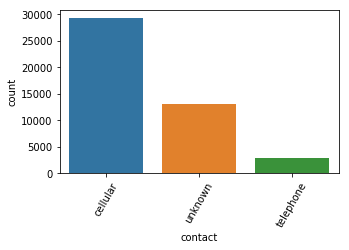

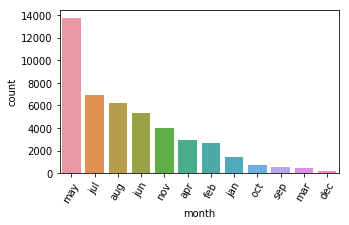

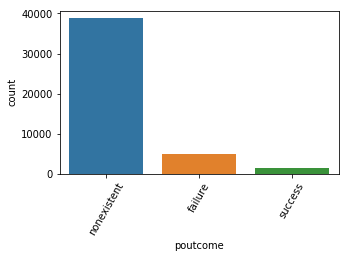

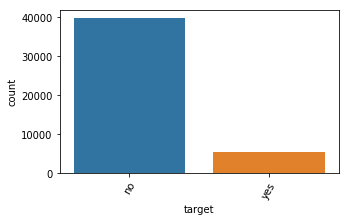

In [0]:
for x in lista_var_str:
  value_counts = loan_df2.groupBy(x).count().sort(F.col('count'),ascending=False).toPandas()
  plt.figure(figsize=(5,3))
  sns.barplot(value_counts[x], value_counts['count'])
  plt.xticks(rotation=60)


Para las variables cuantitativas, calculamos además la media, máximo, mínimo y desviación típica:


In [0]:
avgs = [F.avg(col).alias('avg_' + col) for col in lista_var_int]
maxs = [F.max(col).alias('max_' + col) for col in lista_var_int]
mins = [F.min(col).alias('min_' + col) for col in lista_var_int]
stds = [F.stddev(col).alias('std_' + col) for col in lista_var_int]


In [0]:
operations = avgs + stds + maxs + mins 
operations

[Column<b'avg(age) AS `avg_age`'>,
 Column<b'avg(balance) AS `avg_balance`'>,
 Column<b'avg(day) AS `avg_day`'>,
 Column<b'avg(year) AS `avg_year`'>,
 Column<b'avg(duration) AS `avg_duration`'>,
 Column<b'avg(campaign) AS `avg_campaign`'>,
 Column<b'avg(pdays) AS `avg_pdays`'>,
 Column<b'avg(previous) AS `avg_previous`'>,
 Column<b'avg(picked_up_call) AS `avg_picked_up_call`'>,
 Column<b'avg(default_bin) AS `avg_default_bin`'>,
 Column<b'avg(housing_bin) AS `avg_housing_bin`'>,
 Column<b'avg(loan_bin) AS `avg_loan_bin`'>,
 Column<b'avg(target_bin) AS `avg_target_bin`'>,
 Column<b'stddev_samp(age) AS `std_age`'>,
 Column<b'stddev_samp(balance) AS `std_balance`'>,
 Column<b'stddev_samp(day) AS `std_day`'>,
 Column<b'stddev_samp(year) AS `std_year`'>,
 Column<b'stddev_samp(duration) AS `std_duration`'>,
 Column<b'stddev_samp(campaign) AS `std_campaign`'>,
 Column<b'stddev_samp(pdays) AS `std_pdays`'>,
 Column<b'stddev_samp(previous) AS `std_previous`'>,
 Column<b'stddev_samp(picked_up_cal

In [0]:
results = loan_df2.select(operations).first()

for col in lista_var_int:
   
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
   
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))


age: avg=40.94, std=10.62, min=18, max=95
balance: avg=1362.27, std=3044.77, min=-8019, max=102127
day: avg=15.81, std=8.32, min=1, max=31
year: avg=2008.44, std=0.6, min=2008, max=2010
duration: avg=258.16, std=257.53, min=0, max=4918
campaign: avg=2.76, std=3.1, min=1, max=63
pdays: avg=857.57, std=303.25, min=1, max=999
previous: avg=0.58, std=2.3, min=0, max=275
picked_up_call: avg=1.0, std=0.01, min=0, max=1
default_bin: avg=0.02, std=0.13, min=0, max=1
housing_bin: avg=0.56, std=0.5, min=0, max=1
loan_bin: avg=0.16, std=0.37, min=0, max=1
target_bin: avg=0.12, std=0.32, min=0, max=1


Otra forma de verlo más visual:

In [0]:
loan_df2.select(lista_var_int).describe().toPandas()

,summary,age,balance,day,year,duration,campaign,pdays,previous,picked_up_call,default_bin,housing_bin,loan_bin,target_bin
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,1362.2720576850766,15.80641879188693,2008.444626307757,258.1630797814691,2.763840658246887,857.5652827851629,0.5803233726305546,0.9999336444670545,0.018026586450200173,0.5558381809736569,0.16022649355245405,0.11698480458295547
2,stddev,10.618762040975405,3044.7658291685257,8.322476153044594,0.6023643227279073,257.5278122651706,3.098020883279192,303.24569088335704,2.303441044931218,0.008145710374757153,0.1330489390167441,0.4968778102619627,0.3668200383232984,0.32140573261566385
3,min,18,-8019,1,2008,0,1,1,0,0,0,0,0,0
4,max,95,102127,31,2010,4918,63,999,275,1,1,1,1,1


# Outliers

Creamos una función que utiliza Tukey para la detección de outliers y añade una columna binaria para identificar los outliers para cada variables

In [0]:
lista_var_int

['age',
 'balance',
 'day',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'picked_up_call',
 'default_bin',
 'housing_bin',
 'loan_bin',
 'target_bin']

In [0]:
def remove_tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 1.5 * IQR
    max_thresh = q3 + 1.5 * IQR
    
    df_flag_outliers = df.withColumn(col+'_outl',F.when(F.col(col).between(min_thresh, max_thresh),0).otherwise(1))
    
    return df_flag_outliers

Creamos la lista de las variables int susceptibles de tener outliers y aplicamos la función anterior

In [0]:

lista_var_int_outl=['age','duration','balance','campaign','previous']
for c in lista_var_int_outl:
  loan_df2=remove_tukey_outliers(loan_df2,c)

In [0]:
loan_df2.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+-----------+------+--------------+-----------+-----------+--------+----------+----------+--------+-------------+------------+-------------+-------------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|   poutcome|target|picked_up_call|default_bin|housing_bin|loan_bin|target_bin|      date|age_outl|duration_outl|balance_outl|campaign_outl|previous_outl|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+-----------+------+--------------+-----------+-----------+--------+----------+----------+--------+-------------+------------+-------------+-------------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|  999|       0|nonexistent|    no|             1|          0|    

Una vez que tenemos todas las marcas con outliers, creamos un sumatorio para filtrar únicamente los registros que no tienen ningún outlier marcado (=0)

In [0]:
loan_df3=loan_df2.withColumn('total_outl',(F.col('age_outl')+F.col('duration_outl')+F.col('balance_outl')+F.col('campaign_outl')))

In [0]:
loan_df3.groupby(F.col('total_outl')).count().show()

+----------+-----+
|total_outl|count|
+----------+-----+
|         1| 9621|
|         3|   34|
|         4|    1|
|         2|  962|
|         0|34593|
+----------+-----+



Filtramos el df por los registros que no tienen ningún outlier y comprobamos dimensión

In [0]:
loan_df4=loan_df3.filter(F.col('total_outl')==0)
size(loan_df4)

[34593, 30]

# Análisis multivariante

## Matriz de correlación

In [0]:
loan_df4.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('target', 'string'),
 ('picked_up_call', 'int'),
 ('default_bin', 'int'),
 ('housing_bin', 'int'),
 ('loan_bin', 'int'),
 ('target_bin', 'int'),
 ('date', 'date'),
 ('age_outl', 'int'),
 ('duration_outl', 'int'),
 ('balance_outl', 'int'),
 ('campaign_outl', 'int'),
 ('previous_outl', 'int'),
 ('total_outl', 'int')]

- Limpiamos df para crear la matriz de correlación

In [0]:
lista_drop=['age_outl', 'duration_outl', 'balance_outl', 'campaign_outl', 'total_outl','day','default','housing', 'loan','target','previous_outl']

In [0]:
for x in lista_drop:
  loan_df4=loan_df4.drop(F.col(x))

In [0]:
loan_df4.show()

+---+------------+--------+---------+-------+-------+-----+----+--------+--------+-----+--------+-----------+--------------+-----------+-----------+--------+----------+----------+
|age|         job| marital|education|balance|contact|month|year|duration|campaign|pdays|previous|   poutcome|picked_up_call|default_bin|housing_bin|loan_bin|target_bin|      date|
+---+------------+--------+---------+-------+-------+-----+----+--------+--------+-----+--------+-----------+--------------+-----------+-----------+--------+----------+----------+
| 58|  management| married| tertiary|   2143|unknown|  may|2008|     261|       1|  999|       0|nonexistent|             1|          0|          1|       0|         0|2008-05-05|
| 44|  technician|  single|secondary|     29|unknown|  may|2008|     151|       1|  999|       0|nonexistent|             1|          0|          1|       0|         0|2008-05-05|
| 33|entrepreneur| married|secondary|      2|unknown|  may|2008|      76|       1|  999|       0|non

In [0]:
size(loan_df4)

[34593, 19]

- Actualizmaos lista de variables int y str.

In [0]:
lista_var = loan_df4.dtypes
lista_var_int = [c for c,t in lista_var if t in ['int','double']]
lista_var_str = [c for c,t in lista_var if t in ['string','boolean']]

In [0]:
lista_var_int

['age',
 'balance',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'picked_up_call',
 'default_bin',
 'housing_bin',
 'loan_bin',
 'target_bin']

In [0]:
corr_matrix = Statistics.corr(loan_df4.select(lista_var_int).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix

array([[ 1.        ,  0.08312921, -0.07593809, -0.03374338,  0.03961157,
         0.01242957, -0.00729291, -0.00507456, -0.01441808, -0.15289554,
         0.00656661, -0.00704636],
       [ 0.08312921,  1.        ,  0.08948057,  0.02624673, -0.02617838,
        -0.07575213,  0.03493162, -0.01097944, -0.13005243, -0.06132587,
        -0.09403889,  0.09076163],
       [-0.07593809,  0.08948057,  1.        ,  0.06257989, -0.13965953,
        -0.49811504,  0.27840375, -0.01955005, -0.06344667, -0.05779404,
        -0.10060203,  0.38180333],
       [-0.03374338,  0.02624673,  0.06257989,  1.        , -0.07435692,
        -0.02781405,  0.01546659, -0.01257522, -0.00158216,  0.00235645,
        -0.00803439,  0.25742283],
       [ 0.03961157, -0.02617838, -0.13965953, -0.07435692,  1.        ,
         0.09185417, -0.00481899, -0.00500023,  0.01152964, -0.03620052,
        -0.0026653 , -0.07988792],
       [ 0.01242957, -0.07575213, -0.49811504, -0.02781405,  0.09185417,
         1.        , -

In [0]:
corr_matrix = pd.DataFrame(corr_matrix, columns=lista_var_int, index=lista_var_int)
corr_matrix

,age,balance,year,duration,campaign,pdays,previous,picked_up_call,default_bin,housing_bin,loan_bin,target_bin
age,1.000000,0.083129,-0.075938,-0.033743,0.039612,0.012430,-0.007293,-0.005075,-0.014418,-0.152896,0.006567,-0.007046
balance,0.083129,1.000000,0.089481,0.026247,-0.026178,-0.075752,0.034932,-0.010979,-0.130052,-0.061326,-0.094039,0.090762
year,-0.075938,0.089481,1.000000,0.062580,-0.139660,-0.498115,0.278404,-0.019550,-0.063447,-0.057794,-0.100602,0.381803
duration,-0.033743,0.026247,0.062580,1.000000,-0.074357,-0.027814,0.015467,-0.012575,-0.001582,0.002356,-0.008034,0.257423
campaign,0.039612,-0.026178,-0.139660,-0.074357,1.000000,0.091854,-0.004819,-0.005000,0.011530,-0.036201,-0.002665,-0.079888
pdays,0.012430,-0.075752,-0.498115,-0.027814,0.091854,1.000000,-0.505814,0.006510,0.042972,-0.045897,0.029518,-0.216031
previous,-0.007293,0.034932,0.278404,0.015467,-0.004819,-0.505814,1.000000,-0.015678,-0.017705,0.040608,-0.007260,0.110834
picked_up_call,-0.005075,-0.010979,-0.019550,-0.012575,-0.005000,0.006510,-0.015678,1.000000,0.001073,0.008769,0.003451,0.002291
default_bin,-0.014418,-0.130052,-0.063447,-0.001582,0.011530,0.042972,-0.017705,0.001073,1.000000,-0.010251,0.070915,-0.023578
housing_bin,-0.152896,-0.061326,-0.057794,0.002356,-0.036201,-0.045897,0.040608,0.008769,-0.010251,1.000000,0.032008,-0.161923


NOs quedamos con el triangulo de abajo

In [0]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True],
       [False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True],
       [False, False, False, False, False, False, False,  True,  True,
         True,  True,  True],
       [False, False, False, False, False, False, False, False,  True,
         True,  True,  True],
       [False, False, False, False, False, False, False, False, False,
         True,  True

In [0]:
corr_matrix = corr_matrix.mask(mask)
corr_matrix

,age,balance,year,duration,campaign,pdays,previous,picked_up_call,default_bin,housing_bin,loan_bin,target_bin
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.083129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,-0.075938,0.089481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.033743,0.026247,0.062580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,0.039612,-0.026178,-0.139660,-0.074357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pdays,0.012430,-0.075752,-0.498115,-0.027814,0.091854,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,-0.007293,0.034932,0.278404,0.015467,-0.004819,-0.505814,NaN,NaN,NaN,NaN,NaN,NaN
picked_up_call,-0.005075,-0.010979,-0.019550,-0.012575,-0.005000,0.006510,-0.015678,NaN,NaN,NaN,NaN,NaN
default_bin,-0.014418,-0.130052,-0.063447,-0.001582,0.011530,0.042972,-0.017705,0.001073,NaN,NaN,NaN,NaN
housing_bin,-0.152896,-0.061326,-0.057794,0.002356,-0.036201,-0.045897,0.040608,0.008769,-0.010251,NaN,NaN,NaN


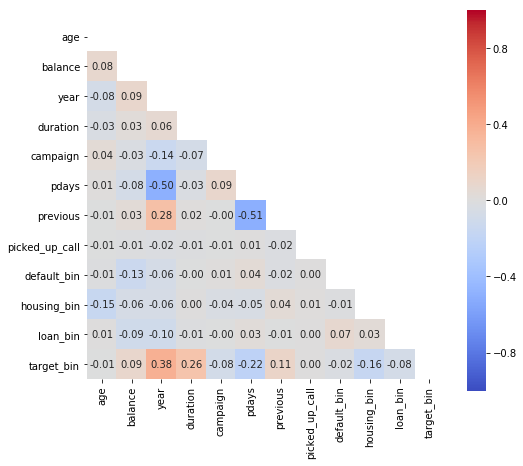

In [0]:

plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no')